# Designing networks

`Networks` are how Nengo encapsulates
functionally complementary objects.
Networks can contain
ensembles, nodes, connection, even other networks.
Models are often made much more readable
my grouping objects into networks.
Tools for visualizing networks
will often use the network structure
to produce cleaner images.

Here, we will go over some general principles
of network design. In the first section,
we will go over these principles with a simple example.
In the second section, we will apply
these principles to a more complicated example.

Briefly, the general principles we will
go over in this tutorial are

0. Group related objects in networks with `with`
0. Reuse networks by defining functions
0. Parameterize functions for more flexible reuse

We will demonstrate these principles
with a network consisting
of two connected integrators
as an example.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import nengo
from nengo.dists import Choice
from nengo.processes import Piecewise
from nengo.utils.ipython import hide_input


def test_integrators(net):
    with net:
        piecewise = Piecewise({
            0: 0,
            0.2: 0.5,
            1: 0,
            2: -1,
            3: 0,
            4: 1,
            5: 0
        })
        piecewise_inp = nengo.Node(piecewise)
        nengo.Connection(piecewise_inp, net.pre_integrator.input)
        input_probe = nengo.Probe(piecewise_inp)
        pre_probe = nengo.Probe(net.pre_integrator.ensemble, synapse=0.01)
        post_probe = nengo.Probe(net.post_integrator.ensemble, synapse=0.01)
    with nengo.Simulator(net) as sim:
        sim.run(6)
    plt.figure()
    plt.plot(sim.trange(), sim.data[input_probe], color='k')
    plt.plot(sim.trange(), sim.data[pre_probe], color='b')
    plt.plot(sim.trange(), sim.data[post_probe], color='g')


hide_input()

## 1. Group related objects in networks with `with`

All Nengo objects must be created
in the context of some network.
We use the `with` keyword to denote
the network context in which
a Nengo object is created.

These `with` statements can be nested
to group objects in appropriately named networks.

In [2]:
# Example: two connected integrators
#  (See integrator example network for more details)
net = nengo.Network(label="Two integrators")
with net:
    with nengo.Network() as pre_integrator:
        pre_input = nengo.Node(size_in=1)
        pre_ensemble = nengo.Ensemble(100, dimensions=1)
        nengo.Connection(pre_ensemble, pre_ensemble, synapse=0.1)
        nengo.Connection(pre_input, pre_ensemble, synapse=None, transform=0.1)
    with nengo.Network() as post_integrator:
        post_input = nengo.Node(size_in=1)
        post_ensemble = nengo.Ensemble(100, dimensions=1)
        nengo.Connection(post_ensemble, post_ensemble, synapse=0.1)
        nengo.Connection(
            post_input, post_ensemble, synapse=None, transform=0.1)
    nengo.Connection(pre_ensemble, post_input)

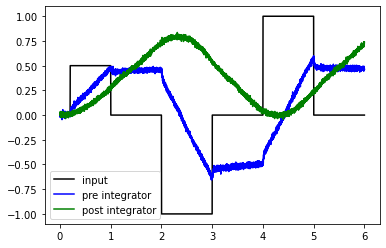

In [3]:
# Test the integrators by giving piecewise input and plotting
with net:
    piecewise = Piecewise({0: 0, 0.2: 0.5, 1: 0, 2: -1, 3: 0, 4: 1, 5: 0})
    piecewise_inp = nengo.Node(piecewise)
    nengo.Connection(piecewise_inp, pre_input)
    input_probe = nengo.Probe(piecewise_inp)
    pre_probe = nengo.Probe(pre_ensemble, synapse=0.01)
    post_probe = nengo.Probe(post_ensemble, synapse=0.01)
with nengo.Simulator(net) as sim:
    sim.run(6)
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], color='k', label="input")
plt.plot(sim.trange(), sim.data[pre_probe], color='b', label="pre integrator")
plt.plot(
    sim.trange(), sim.data[post_probe], color='g', label="post integrator")
plt.legend(loc='best')

Note that the `with` statements
are not just cosmetic;
Nengo objects are stored
in the network that they're constructed in.

In [4]:
assert pre_input in pre_integrator
assert pre_input not in net
assert pre_integrator in net

## 2. Reuse networks by defining functions

Often, the same network is constructed
more than once, resulting in duplicated code.
We can reduce this code duplication
by defining a function that
creates the network and returns it.

Even if you only use the network once,
it can be helpful to define all of
your subnetworks in functions
to keep your code cleaner.
Determining when a network
should be defined in a function
is informed by experience
designing large networks
and personal preference.

### Store useful objects on the network

A corollary to putting networks in functions
is that any objects that you might want
access to outside of that function
should be stored on the network.
Functions that create networks
should only return that network.
While all objects in that network
are stored somewhere
(e.g., ensembles are stored in a `net.ensembles` list),
that list can be large and difficult to search.
Therefore, we recommend storing objects
on the network itself
to make them accessible outside of the function.

In [5]:
# Example: two connected integrators. Now with functions!
def Integrator1():
    with nengo.Network() as integrator:
        integrator.input = nengo.Node(size_in=1)
        integrator.ensemble = nengo.Ensemble(100, dimensions=1)
        nengo.Connection(integrator.ensemble, integrator.ensemble, synapse=0.1)
        nengo.Connection(
            integrator.input, integrator.ensemble, synapse=None, transform=0.1)
    return integrator


net = nengo.Network(label="Two integrators")
with net:
    net.pre_integrator = Integrator1()
    net.post_integrator = Integrator1()
    nengo.Connection(net.pre_integrator.ensemble, net.post_integrator.input)

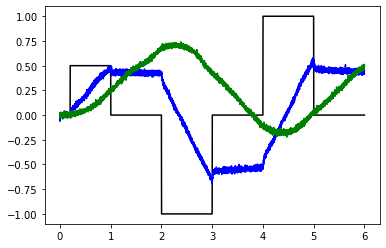

In [6]:
# This function does the same as the previous example
test_integrators(net)

## 3. Parameterize functions for more flexible reuse

Now that your network is created in a function,
you can add parameters to your function
to change how your network is constructed.
This could be a huge change,
allowing you to compare two different approaches
to some component of your model,
or it could something straightforward
like changing the number of neurons
in the ensembles in the network.

Unlike other languages, Python allows you
to add two different types of parameters:
**positional** and **keyword** arguments.
Positional arguments must be passed
to your function.

```python
>>> def my_network(arg1, arg2):
...     return "%s %s" % (arg1, arg2)
>>> my_network()
TypeError: my_network() takes exactly 2 arguments (0 given)
>>> my_network(0, 0)
'0 0'
```

Keyword arguments are assigned a default value,
and so do not have to be passed to your function.

```python
>>> def my_network(arg1=0, arg2=0):
...     return "%s %s" % (arg1, arg2)
>>> my_network()
'0 0'
>>> my_network(1)
'1 0'
```

Order does not matter if you explicitly
label the argument in your function call.

```python
>>> my_network(arg2=2, arg1=1)
'1 2'
>>> my_network(arg2=2)
'0 2'
```

In [7]:
# Example: two connected integrators. Functions have parameters!
def Integrator2(n_neurons, dimensions, tau=0.1):
    with nengo.Network() as integrator:
        integrator.input = nengo.Node(size_in=dimensions)
        integrator.ensemble = nengo.Ensemble(n_neurons, dimensions=dimensions)
        nengo.Connection(integrator.ensemble, integrator.ensemble, synapse=tau)
        nengo.Connection(
            integrator.input, integrator.ensemble, synapse=None, transform=tau)
    return integrator

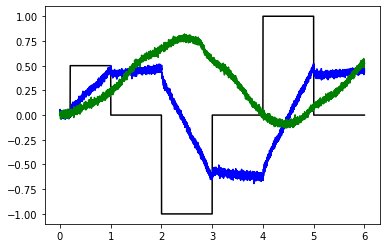

In [8]:
# Try 50 neuron ensembles
net = nengo.Network(label="Two integrators")
with net:
    net.pre_integrator = Integrator2(50, 1)
    net.post_integrator = Integrator2(50, 1)
    nengo.Connection(net.pre_integrator.ensemble, net.post_integrator.input)
test_integrators(net)

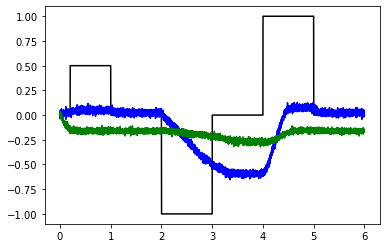

In [9]:
# Try shorter tau (spoiler: it fails to integrate well)
net = nengo.Network(label="Two integrators")
with net:
    net.pre_integrator = Integrator2(50, 1, tau=0.01)
    net.post_integrator = Integrator2(50, 1, tau=0.01)
    nengo.Connection(net.pre_integrator.ensemble, net.post_integrator.input)
test_integrators(net)

## Longer example: double integrator network

While the coupled integrator model above
seems like a toy example,
it is in fact a critical component
of many models that capture
neurophysiological and behavioral data.
Let's looks at a more complicated network
that uses coupled integrators,
and show how the network design principles
discussed above improve model organization.
We will look at a simplified version
of the network described in
[Bekolay et al., 2014](
http://compneuro.uwaterloo.ca/files/publications/bekolay.2014a.pdf).

This network uses two coupled integrators
in the context of a simple reaction time task.
The subject presses down a lever,
and should release that lever
between 0.6 and 1.0 seconds later.
In order to time the interval,
the lever press starts the coupled integrators,
which are tuned such that
the second integrator should reach
a high point by around 0.6 seconds.
The second integrator
effects the lever release.

We'll start with a completely disorganized network.
Even if you've read the paper,
the code is quite hard to follow.

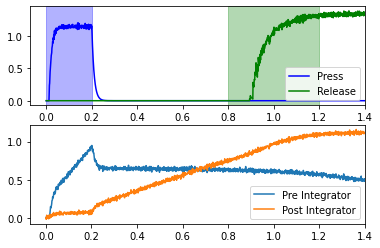

In [10]:
with nengo.Network() as net:
    tau = 0.1

    pre_integrator = nengo.Ensemble(200, dimensions=2)
    nengo.Connection(
        pre_integrator,
        pre_integrator[0],
        function=lambda x: x[0] * (1.0 - x[1]),
        synapse=tau)
    post_integrator = nengo.Ensemble(200, dimensions=2)
    nengo.Connection(
        post_integrator,
        post_integrator[0],
        function=lambda x: x[0] * (1.0 - x[1]),
        synapse=tau)
    nengo.Connection(pre_integrator[0], post_integrator[0], transform=0.16)
    press = nengo.Ensemble(
        30, dimensions=1, encoders=Choice([[1]]), intercepts=Choice([0.85]))
    release = nengo.Ensemble(
        30, dimensions=1, encoders=Choice([[1]]), intercepts=Choice([0.85]))

    nengo.Connection(press, pre_integrator[0], transform=tau * 3)
    nengo.Connection(press, post_integrator[1], transform=-1 * 6)

    nengo.Connection(post_integrator[0], release)
    nengo.Connection(nengo.Node(lambda t: 1 if t < 0.2 else 0), press)

    pr_press = nengo.Probe(press, synapse=0.01)
    pr_release = nengo.Probe(release, synapse=0.01)
    pr_pre_int = nengo.Probe(pre_integrator[0], synapse=0.01)
    pr_post_int = nengo.Probe(post_integrator[0], synapse=0.01)


def test_doubleintegrator(net):
    with nengo.Simulator(net) as sim:
        sim.run(1.4)
    t = sim.trange()
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, sim.data[pr_press], c='b', label="Press")
    plt.plot(t, sim.data[pr_release], c='g', label="Release")
    plt.axvspan(0, 0.2, color='b', alpha=0.3)
    plt.axvspan(0.8, 1.2, color='g', alpha=0.3)
    plt.xlim(right=1.4)
    plt.legend(loc="best")
    plt.subplot(2, 1, 2)
    plt.plot(t, sim.data[pr_pre_int], label="Pre Integrator")
    plt.plot(t, sim.data[pr_post_int], label="Post Integrator")
    plt.xlim(right=1.4)
    plt.legend(loc="best")


test_doubleintegrator(net)

Recall that the goal is to release the lever
0.6-1.0 seconds after the press.
The blue "Press" line in the upper plot
represents the activity of neurons
in motor cortex which effect the lever press.
If we assume that the press occurs at 0.2 seconds,
then the release window is between 0.8 and 1.2 seconds
(shown in green).
This will occur if the "Post Integrator" (see lower plot)
is sufficiently high during this window.
If you rerun the cell above several times,
you can see that it usually achieves this,
but not all of the time.

Looking at the code, it's difficult to tell
how we achieve this result.
It's also difficult to see what parameters
needed tweaking.
Rather than just showing one parameter set that works,
we should investigate reasonable ranges for
each parameter.
It would be easy to think that there is only
one parameter, `tau`, in the model as presented,
but this is not the case.

Let's start with the first network design principle:
group objects into networks with `with`.

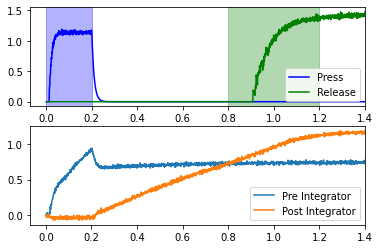

In [11]:
with nengo.Network() as net:
    tau = 0.1

    with nengo.Network() as mpfc:
        with nengo.Network() as pre_integrator:
            pre_ensemble = nengo.Ensemble(200, dimensions=2)
            nengo.Connection(
                pre_ensemble,
                pre_ensemble[0],
                function=lambda x: x[0] * (1.0 - x[1]),
                synapse=tau)
        with nengo.Network() as post_integrator:
            post_ensemble = nengo.Ensemble(200, dimensions=2)
            nengo.Connection(
                post_ensemble,
                post_ensemble[0],
                function=lambda x: x[0] * (1.0 - x[1]),
                synapse=tau)
        nengo.Connection(pre_ensemble[0], post_ensemble[0], transform=0.16)

    with nengo.Network() as motor:
        press = nengo.Ensemble(
            30,
            dimensions=1,
            encoders=Choice([[1]]),
            intercepts=Choice([0.85]))
        release = nengo.Ensemble(
            30,
            dimensions=1,
            encoders=Choice([[1]]),
            intercepts=Choice([0.85]))

    nengo.Connection(press, pre_ensemble[0], transform=tau * 3)
    nengo.Connection(press, post_ensemble[1], transform=-1 * 6)

    nengo.Connection(post_ensemble[0], release)
    nengo.Connection(nengo.Node(lambda t: 1 if t < 0.2 else 0), press)

    pr_press = nengo.Probe(press, synapse=0.01)
    pr_release = nengo.Probe(release, synapse=0.01)
    pr_pre_int = nengo.Probe(pre_ensemble[0], synapse=0.01)
    pr_post_int = nengo.Probe(post_ensemble[0], synapse=0.01)

test_doubleintegrator(net)

This exhibits some of the hypotheses of this model;
specifically, that the medial prefrontal cortex
contains these integrators,
and that they can be involved
in control of motor actions.

Let's do both of the remaining principles
by making some parameterized functions
to get a sense of all of the knobs
that be be tweaked in this model.

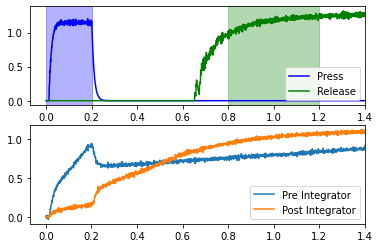

In [12]:
def controlled_integrator(n_neurons, dimensions, tau=0.1):
    with nengo.Network() as integrator:
        integrator.ensemble = nengo.Ensemble(
            n_neurons, dimensions=dimensions + 1)
        nengo.Connection(
            integrator.ensemble,
            integrator.ensemble[:dimensions],
            function=lambda x: x[:-1] * (1.0 - x[-1]),
            synapse=tau)
    return integrator


def medial_pfc(coupling_strength, n_neurons_per_integrator=200, tau=0.1):
    with nengo.Network() as medial_pfc:
        medial_pfc.pre = controlled_integrator(n_neurons_per_integrator, 1,
                                               tau)
        medial_pfc.post = controlled_integrator(n_neurons_per_integrator, 1,
                                                tau)
        nengo.Connection(
            medial_pfc.pre.ensemble[0],
            medial_pfc.post.ensemble[0],
            transform=coupling_strength)
    return medial_pfc


def motor_cortex(command_threshold, n_neurons_per_command=30):
    with nengo.Network() as motor_cortex:
        ens_args = {
            'dimensions': 1,
            'encoders': Choice([[1]]),
            'intercepts': Choice([command_threshold])
        }
        motor_cortex.press = nengo.Ensemble(n_neurons_per_command, **ens_args)
        motor_cortex.release = nengo.Ensemble(n_neurons_per_command,
                                              **ens_args)
    return motor_cortex


def double_integrator(mpfc_coupling_strength,
                      command_threshold,
                      press_to_pre_gain=3,
                      press_to_post_control=-6,
                      recurrent_tau=0.1,
                      seed=None):
    with nengo.Network(seed=seed) as net:
        net.mpfc = medial_pfc(mpfc_coupling_strength)
        net.motor = motor_cortex(command_threshold)
        nengo.Connection(
            net.motor.press,
            net.mpfc.pre.ensemble[0],
            transform=recurrent_tau * press_to_pre_gain)
        nengo.Connection(
            net.motor.press,
            net.mpfc.post.ensemble[1],
            transform=press_to_post_control)
        nengo.Connection(net.mpfc.post.ensemble[0], net.motor.release)
    return net


def test_doubleintegrator_wprobes(net):
    # Provide input and probe outside of network construction,
    # for more flexibility
    with net:
        nengo.Connection(
            nengo.Node(lambda t: 1 if t < 0.2 else 0), net.motor.press)
        pr_press = nengo.Probe(net.motor.press, synapse=0.01)
        pr_release = nengo.Probe(net.motor.release, synapse=0.01)
        pr_pre_int = nengo.Probe(net.mpfc.pre.ensemble[0], synapse=0.01)
        pr_post_int = nengo.Probe(net.mpfc.post.ensemble[0], synapse=0.01)
    with nengo.Simulator(net) as sim:
        sim.run(1.4)
    t = sim.trange()
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, sim.data[pr_press], c='b', label="Press")
    plt.plot(t, sim.data[pr_release], c='g', label="Release")
    plt.axvspan(0, 0.2, color='b', alpha=0.3)
    plt.axvspan(0.8, 1.2, color='g', alpha=0.3)
    plt.xlim(right=1.4)
    plt.legend(loc="best")
    plt.subplot(2, 1, 2)
    plt.plot(t, sim.data[pr_pre_int], label="Pre Integrator")
    plt.plot(t, sim.data[pr_post_int], label="Post Integrator")
    plt.xlim(right=1.4)
    plt.legend(loc="best")


net = double_integrator(mpfc_coupling_strength=0.16, command_threshold=0.85)
test_doubleintegrator_wprobes(net)

While this does add some complexity and length,
the effort is worth it,
as we can now do simple parameters sweeps
to investigate the effects
of changing various parameters.

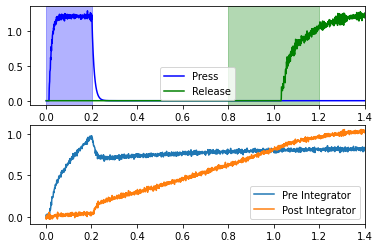

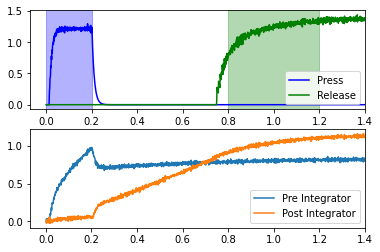

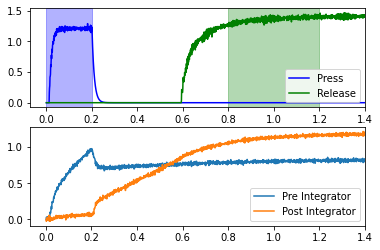

In [13]:
for coupling_strength in (0.11, 0.16, 0.21):
    net = double_integrator(
        mpfc_coupling_strength=coupling_strength,
        command_threshold=0.85,
        seed=0)
    test_doubleintegrator_wprobes(net)

The `coupling_strength` changes how quickly
the "Post Integrator" rises,
which causes the release to occur
at different times.
Of the values tested,
only a coupling strength of 0.16
effects the release during the release window
(for this particular network seed).

We will looks at some more techniques
for cleaning up this network code
and making it more flexible
in "Additional tips and tricks for designing networks".